In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.optim.optimizer
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import random_split
from sklearn.metrics import classification_report, f1_score

print(torch.__version__)

2.4.0


In [2]:
train= pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test= pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

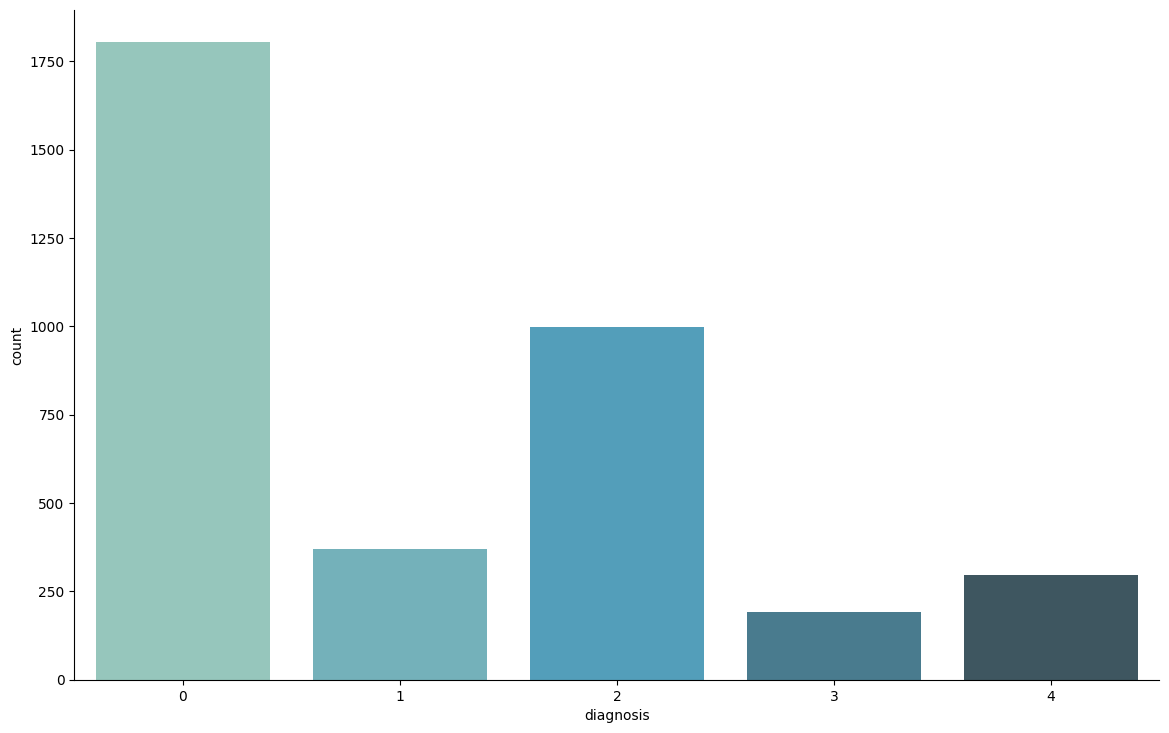

In [4]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

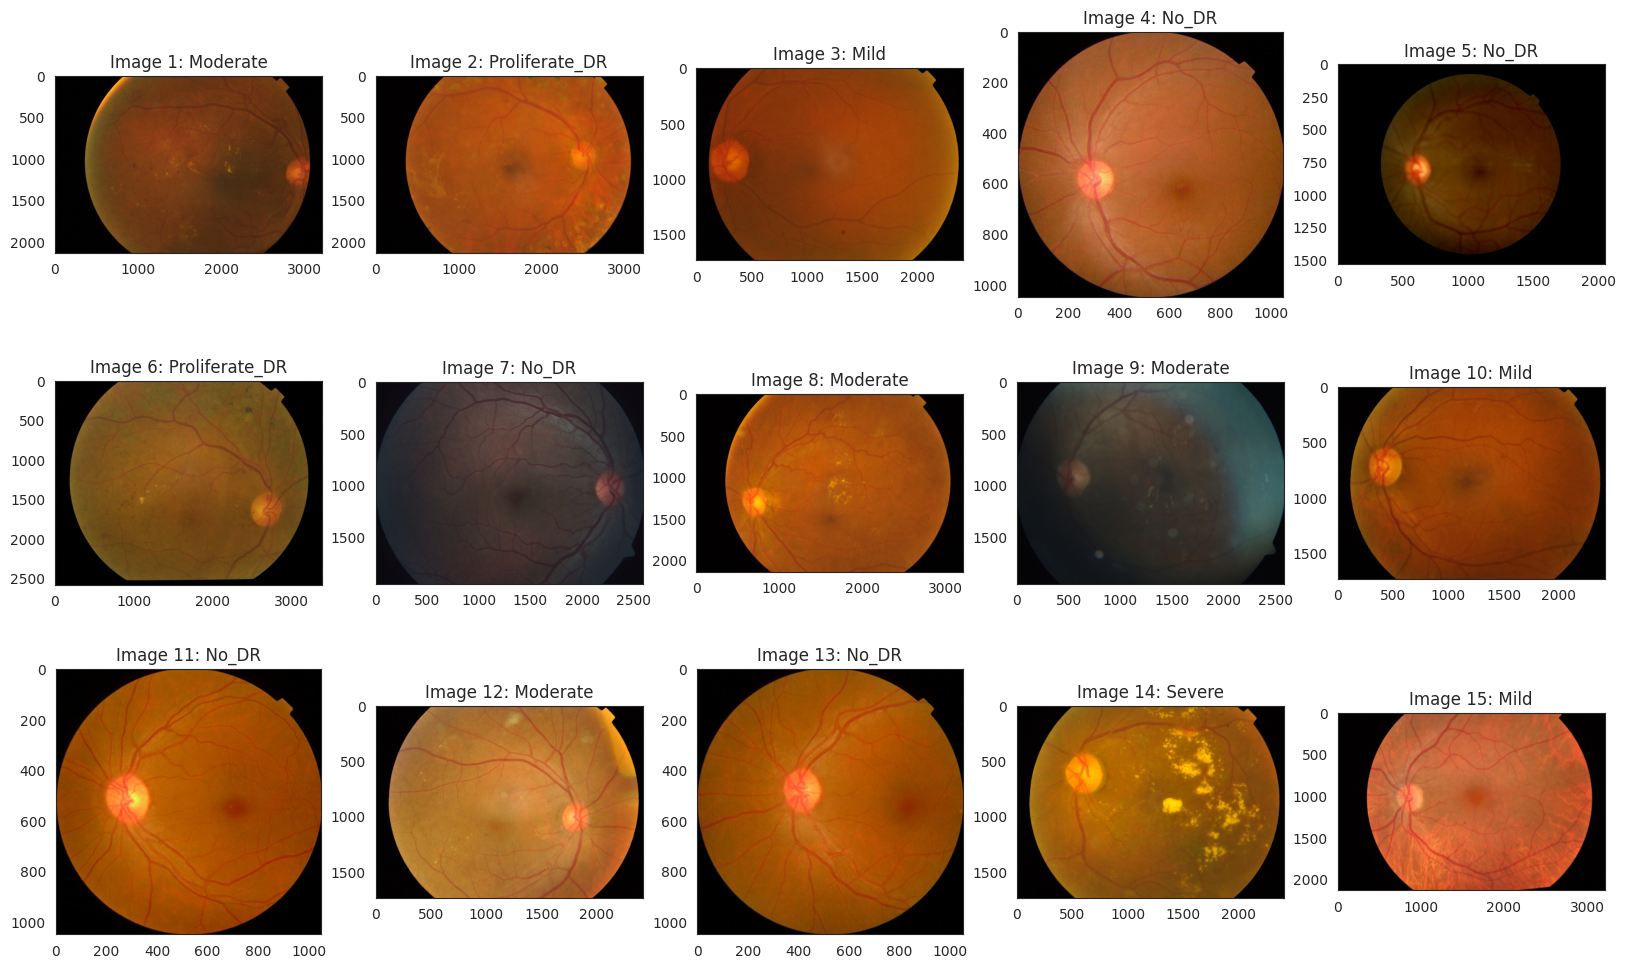

In [5]:
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]: 
    img = cv2.imread(f"../input/aptos2019-blindness-detection/train_images/{img_name}.png")[..., [2, 1, 0]]
    label = train[train['id_code'] == img_name]['diagnosis'].values[0] 
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1
plt.savefig('/kaggle/working/imagebeforepreprecssing.png')
plt.show()


In [7]:
# Function to crop the image based on grayscale threshold
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark so that we crop out everything
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [8]:
input_dir = '/kaggle/input/aptos2019-blindness-detection/train_images/'
output_dir = '/kaggle/working/processed_images/'

os.makedirs(output_dir, exist_ok=True)
csv_path = '/kaggle/input/aptos2019-blindness-detection/train.csv'
df = pd.read_csv(csv_path)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def process_image(row):
    sample_image_id = row['id_code'] 
    sample_image_file = sample_image_id + '.png' 
    sample_image_path = os.path.join(input_dir, sample_image_file)

    if os.path.exists(sample_image_path):
        image = cv2.imread(sample_image_path)
        image_cropped = crop_image_from_gray(image)
        image_resized = cv2.resize(image_cropped, (256, 256))
        blue, green, red = cv2.split(image_resized)
        blue_clahe = clahe.apply(blue)
        green_clahe = clahe.apply(green)
        red_clahe = clahe.apply(red)
        result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
        output_path = os.path.join(output_dir, sample_image_file)
        cv2.imwrite(output_path, result_image)

# Using ThreadPoolExecutor to process images in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(process_image, [row for _, row in df.iterrows()]), total=df.shape[0], desc="Processing images", unit="image"))

print("Processing complete for all images.")


Processing images: 100%|██████████| 3662/3662 [04:24<00:00, 13.85image/s]

Processing complete for all images.


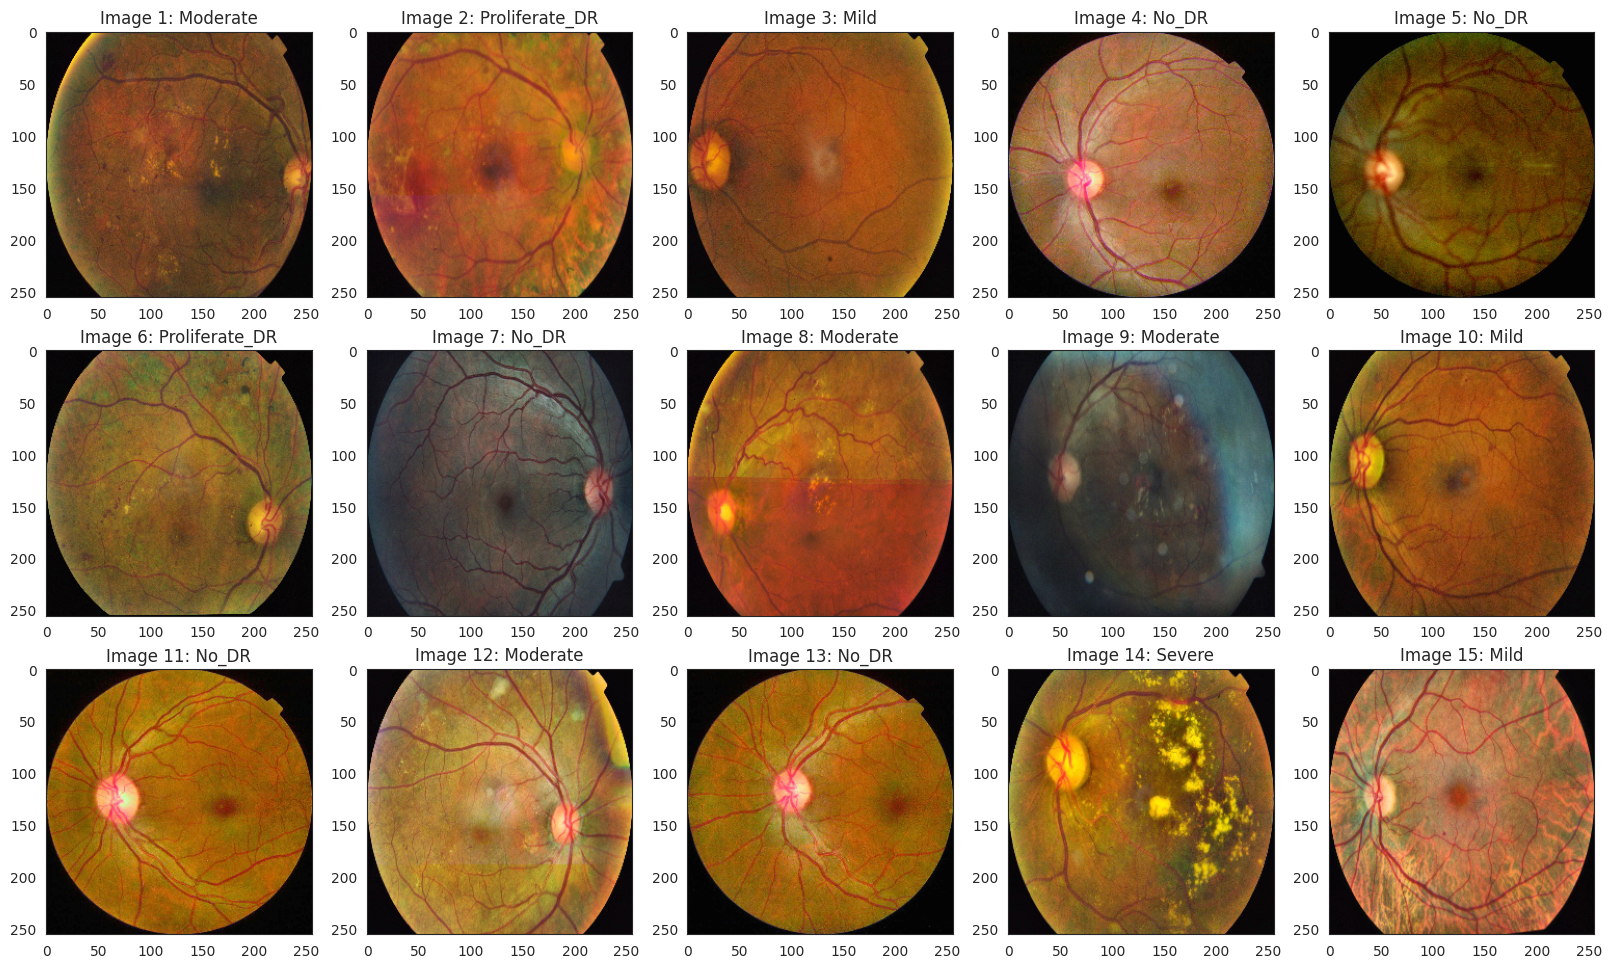

In [9]:
sns.set_style("white")

level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]: 
    img = cv2.imread(f"/kaggle/working/processed_images/{img_name}.png")[..., [2, 1, 0]] 
    label = train[train['id_code'] == img_name]['diagnosis'].values[0] 
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")
    count += 1
plt.show()


In [11]:
DATA_DIR = "/kaggle/working/processed_images"
TRAIN_DIR = "/kaggle/working/processed_images"
CSV_PATH = "/kaggle/input/aptos2019-blindness-detection/train.csv"
MODEL_PATH = "./kaggle/working/"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS=10

In [10]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [12]:
train_trasforms_DeiT_base_patch16= T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_DeiT_base_patch16)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

### Helper Functions and Utilities for Training and Evaluation

In [13]:
@torch.no_grad()
def accuracy(output, target):
    """
    Computes the overall accuracy of predictions.

    Args:
        output (torch.Tensor): Model predictions with shape (batch_size, num_classes).
        target (torch.Tensor): True labels with shape (batch_size,).

    Returns:
        float: Accuracy as a percentage.
    """
    with torch.no_grad():
        _, predicted = output.max(1)  # Get the class index with the highest score
        correct = predicted.eq(target).sum().item()  # Count correct predictions
        total = target.size(0)  # Total number of samples
        accuracy = 100.0 * correct / total  # Compute accuracy percentage

    return accuracy


def set_debug_apis(state: bool = False):
    """
    Configures PyTorch debugging tools.

    Args:
        state (bool): If True, enables debugging tools for profiling and anomaly detection.
    """
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    """
    Sets seeds for reproducibility in training.

    Args:
        seed (int): Seed value to ensure determinism.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Seed for hash-based operations
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # Seed for PyTorch (GPU)
    torch.backends.cudnn.deterministic = True  # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN


def print_size_of_model(model):
    """
    Calculates and prints the size of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose size is to be calculated.
    """
    torch.save(model.state_dict(), "temp.p") 
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)  
    os.remove("temp.p")  



In [14]:
print(torch.cuda.is_available())

True


In [15]:
def train_step(model: torch.nn.Module, train_loader, criterion, device: str, optimizer, scheduler=None, num_batches: int = None, log_interval: int = 100, scaler=None):
    """
    Performs one step of training with progress tracking using tqdm, and updates progress at each epoch.
    """
    model = model.to(device)
    model.train()

    start_train_step = time.time()
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with tqdm(train_loader, desc="Training", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Mixed precision training if scaler is provided
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(inputs)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()


            if scheduler is not None:
                scheduler.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)
            correct_predictions += predicted.eq(target).sum().item()
            total_samples += inputs.size(0)

            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            # Break if num_batches is set and we've reached the limit
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    # Final metrics for the epoch
    end_train_step = time.time()
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples

    print(f"\nEpoch Summary: Time taken for train step = {end_train_step - start_train_step:.2f} sec")
    print(f"Training loss = {metrics['loss']:.4f}, Training accuracy = {metrics['accuracy']:.2f}%")

    return metrics

In [16]:
@torch.no_grad()  
def val_step(model: torch.nn.Module, val_loader, criterion, device: str, num_batches=None, log_interval: int = 100):
    """
    Performs one step of validation with progress tracking using tqdm.

    Args:
        model: A PyTorch CNN Model.
        val_loader: DataLoader for the validation set.
        criterion: Loss function to evaluate.
        device: "cuda" or "cpu".
        num_batches: (optional) Limit validation to a certain number of batches.
        log_interval: (optional) Log after every specified number of batches.
    """
    
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    start_val_step = time.time()  # Track the start time of the validation step
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            output = model(inputs)
            loss = criterion(output, target)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)  # Get predictions
            correct_predictions += predicted.eq(target).sum().item()  
            total_samples += inputs.size(0)

            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    end_val_step = time.time() 
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples
    print(f"\nValidation Summary: Time taken for validation step = {end_val_step - start_val_step:.2f} sec")
    print(f"Validation loss = {metrics['loss']:.4f}, Validation accuracy = {metrics['accuracy']:.2f}%")

    return metrics



In [17]:

MODEL_NAME = "swinv2_small_window16_256"
MODEL_SAVE=  "/kaggle/working/swinv2.csv"
seed_everything(42)
set_debug_apis(False)

# Handle imbalnced Classes 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = train['diagnosis'].values

unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)

class_weight_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [21]:
model= timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)
weights_tensor = torch.tensor(list(class_weight_dict.values())).float()
criterion= nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer= optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

/tmp/ipykernel_23/1414476660.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [23]:
from tqdm import tqdm
import time
import torch
import pandas as pd


train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []


patience = 5 
early_stop_counter = 0
best_val_loss = float('inf')
best_model_state = None

start_time = time.time()

train_batches = len(train_loader)
val_batches = len(val_loader)

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    #training loop
    with tqdm(total=train_batches, desc=f"Training Epoch {epoch+1}", unit="batch") as pbar_train:
        train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics["loss"])
        train_accuracy.append(train_metrics["accuracy"])
        
        pbar_train.set_postfix({
            "Loss": f"{train_metrics['loss']:.4f}",
            "Accuracy": f"{train_metrics['accuracy']:.2f}%"
        })
        pbar_train.update(train_batches) 
    #validation loop
    with tqdm(total=val_batches, desc=f"Validation Epoch {epoch+1}", unit="batch") as pbar_val:

        val_metrics = val_step(model, val_loader, criterion, device)
        val_loss.append(val_metrics["loss"])
        val_accuracy.append(val_metrics["accuracy"])

        pbar_val.set_postfix({
            "Loss": f"{val_metrics['loss']:.4f}",
            "Accuracy": f"{val_metrics['accuracy']:.2f}%"
        })
        pbar_val.update(val_batches)  # Update progress bar to the total number of batches

    current_val_loss = val_metrics["loss"]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
        torch.save(best_model_state, f"{MODEL_NAME}_best.pt")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
    print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")

    checkpoint_path = f"{MODEL_NAME}_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), checkpoint_path)

end_time = time.time()


total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")


metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
})


metrics_df.to_csv(MODEL_SAVE, index=False)
print("Training metrics saved to CSV.")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10



Training Epoch 1:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]/tmp/ipykernel_23/2476107468.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.8085, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:01<02:08,  1.14s/batch, Loss=0.8085, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:02<02:08,  1.14s/batch, Loss=1.0822, Accuracy=62.50%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.01batch/s, Loss=1.0822, Accuracy=62.50%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.01batch/s, Loss=1.0925, Accuracy=63.54%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=1.0925, Accuracy=63.54%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=1.0735, Accuracy=62.50%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08ba


Epoch Summary: Time taken for train step = 102.40 sec
Training loss = 0.9158, Training accuracy = 73.05%



Validation Epoch 1:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.6804, Accuracy=75.00%]

Validation:   5%|▍         | 1/22 [00:00<00:19,  1.08batch/s, Loss=0.6804, Accuracy=75.00%]

Validation:   5%|▍         | 1/22 [00:01<00:19,  1.08batch/s, Loss=0.6415, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:01<00:10,  1.87batch/s, Loss=0.6415, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:01<00:10,  1.87batch/s, Loss=0.5896, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:01<00:07,  2.44batch/s, Loss=0.5896, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:01<00:07,  2.44batch/s, Loss=0.6599, Accuracy=78.91%]

Validation:  18%|█▊        | 4/22 [00:01<00:06,  2.85batch/s, Loss=0.6599, Accuracy=78.91%]

Validation:  18%|█▊        | 4/22 [00:01<00:06,  2.85batch/s, Loss=0.6431, Accuracy=79.38%]

Validation:  23%|██▎       | 5/22 [00:01<00:05,  3.1


Validation Summary: Time taken for validation step = 6.46 sec
Validation loss = 0.7706, Validation accuracy = 75.85%
Best model saved with validation loss: 0.7706

Epoch 1 Summary:
Training loss = 0.9158, Training accuracy = 73.05%
Validation loss = 0.7706, Validation accuracy = 75.85%


Epochs:  10%|█         | 1/10 [01:49<16:24, 109.44s/it]

Epoch 2/10



Training Epoch 2:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.5603, Accuracy=78.12%]

Training:   1%|          | 1/114 [00:01<02:08,  1.14s/batch, Loss=0.5603, Accuracy=78.12%]

Training:   1%|          | 1/114 [00:02<02:08,  1.14s/batch, Loss=0.8365, Accuracy=65.62%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.8365, Accuracy=65.62%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.8934, Accuracy=71.88%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.8934, Accuracy=71.88%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.8288, Accuracy=72.66%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08batch/s, Loss=0.8288, Accuracy=72.66%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.08batch/s, Loss=0.8349, Accuracy=71.88%]

Training:   4%|▍         | 5/114 [00:04<01:39,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.43 sec
Training loss = 0.6883, Training accuracy = 79.77%



Validation Epoch 2:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.3991, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.3991, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.4631, Accuracy=82.81%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.82batch/s, Loss=0.4631, Accuracy=82.81%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.82batch/s, Loss=0.4129, Accuracy=83.33%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.20batch/s, Loss=0.4129, Accuracy=83.33%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.20batch/s, Loss=0.5025, Accuracy=80.47%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.5025, Accuracy=80.47%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.4911, Accuracy=80.00%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.02 sec
Validation loss = 0.5889, Validation accuracy = 79.26%
Best model saved with validation loss: 0.5889

Epoch 2 Summary:
Training loss = 0.6883, Training accuracy = 79.77%
Validation loss = 0.5889, Validation accuracy = 79.26%


Epochs:  20%|██        | 2/10 [03:38<14:34, 109.33s/it]

Epoch 3/10



Training Epoch 3:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3819, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:11,  1.17s/batch, Loss=0.3819, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:02<02:11,  1.17s/batch, Loss=0.7743, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.01s/batch, Loss=0.7743, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.01s/batch, Loss=0.7225, Accuracy=78.12%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.7225, Accuracy=78.12%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.6503, Accuracy=79.69%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.07batch/s, Loss=0.6503, Accuracy=79.69%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.07batch/s, Loss=0.6716, Accuracy=78.12%]

Training:   4%|▍         | 5/114 [00:04<01:40,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.45 sec
Training loss = 0.5537, Training accuracy = 83.69%



Validation Epoch 3:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2615, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.08batch/s, Loss=0.2615, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.08batch/s, Loss=0.4195, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.83batch/s, Loss=0.4195, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.83batch/s, Loss=0.3757, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.22batch/s, Loss=0.3757, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.22batch/s, Loss=0.4133, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.4133, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.4028, Accuracy=82.50%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.00 sec
Validation loss = 0.4506, Validation accuracy = 82.10%
Best model saved with validation loss: 0.4506

Epoch 3 Summary:
Training loss = 0.5537, Training accuracy = 83.69%
Validation loss = 0.4506, Validation accuracy = 82.10%


Epochs:  30%|███       | 3/10 [05:27<12:44, 109.27s/it]

Epoch 4/10



Training Epoch 4:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3345, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:10,  1.16s/batch, Loss=0.3345, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:02<02:10,  1.16s/batch, Loss=0.6089, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.6089, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.6375, Accuracy=78.12%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.6375, Accuracy=78.12%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.5525, Accuracy=79.69%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.07batch/s, Loss=0.5525, Accuracy=79.69%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.07batch/s, Loss=0.5323, Accuracy=80.00%]

Training:   4%|▍         | 5/114 [00:04<01:40,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.44 sec
Training loss = 0.4995, Training accuracy = 84.92%



Validation Epoch 4:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2062, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.07batch/s, Loss=0.2062, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.07batch/s, Loss=0.4207, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.84batch/s, Loss=0.4207, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.84batch/s, Loss=0.3358, Accuracy=89.58%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.22batch/s, Loss=0.3358, Accuracy=89.58%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.22batch/s, Loss=0.3829, Accuracy=86.72%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.3829, Accuracy=86.72%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.3577, Accuracy=86.88%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.02 sec
Validation loss = 0.3274, Validation accuracy = 88.49%
Best model saved with validation loss: 0.3274

Epoch 4 Summary:
Training loss = 0.4995, Training accuracy = 84.92%
Validation loss = 0.3274, Validation accuracy = 88.49%


Epochs:  40%|████      | 4/10 [07:17<10:55, 109.26s/it]

Epoch 5/10



Training Epoch 5:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2239, Accuracy=93.75%]

Training:   1%|          | 1/114 [00:01<02:10,  1.16s/batch, Loss=0.2239, Accuracy=93.75%]

Training:   1%|          | 1/114 [00:02<02:10,  1.16s/batch, Loss=0.3212, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.3212, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.3214, Accuracy=87.50%]

Training:   3%|▎         | 3/114 [00:02<01:46,  1.05batch/s, Loss=0.3214, Accuracy=87.50%]

Training:   3%|▎         | 3/114 [00:03<01:46,  1.05batch/s, Loss=0.3476, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.07batch/s, Loss=0.3476, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.07batch/s, Loss=0.3714, Accuracy=86.88%]

Training:   4%|▍         | 5/114 [00:04<01:40,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.85 sec
Training loss = 0.2906, Training accuracy = 91.64%



Validation Epoch 5:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.1670, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.1670, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.2059, Accuracy=92.19%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.82batch/s, Loss=0.2059, Accuracy=92.19%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.82batch/s, Loss=0.1798, Accuracy=92.71%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.20batch/s, Loss=0.1798, Accuracy=92.71%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.20batch/s, Loss=0.2296, Accuracy=89.84%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.2296, Accuracy=89.84%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.2652, Accuracy=89.38%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.03 sec
Validation loss = 0.2437, Validation accuracy = 89.49%
Best model saved with validation loss: 0.2437

Epoch 5 Summary:
Training loss = 0.2906, Training accuracy = 91.64%
Validation loss = 0.2437, Validation accuracy = 89.49%


Epochs:  50%|█████     | 5/10 [09:06<09:07, 109.41s/it]

Epoch 6/10



Training Epoch 6:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.0867, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:01<02:08,  1.14s/batch, Loss=0.0867, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:02<02:08,  1.14s/batch, Loss=0.2210, Accuracy=90.62%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.01batch/s, Loss=0.2210, Accuracy=90.62%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.01batch/s, Loss=0.2247, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.2247, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.2289, Accuracy=88.28%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08batch/s, Loss=0.2289, Accuracy=88.28%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.08batch/s, Loss=0.2792, Accuracy=86.25%]

Training:   4%|▍         | 5/114 [00:04<01:39,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.44 sec
Training loss = 0.2398, Training accuracy = 92.79%



Validation Epoch 6:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.1600, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.1600, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.05batch/s, Loss=0.1276, Accuracy=98.44%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.80batch/s, Loss=0.1276, Accuracy=98.44%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.80batch/s, Loss=0.1277, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.19batch/s, Loss=0.1277, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.19batch/s, Loss=0.2056, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.41batch/s, Loss=0.2056, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.41batch/s, Loss=0.2248, Accuracy=93.75%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.02 sec
Validation loss = 0.2077, Validation accuracy = 95.03%
Best model saved with validation loss: 0.2077

Epoch 6 Summary:
Training loss = 0.2398, Training accuracy = 92.79%
Validation loss = 0.2077, Validation accuracy = 95.03%


Epochs:  60%|██████    | 6/10 [10:56<07:17, 109.36s/it]

Epoch 7/10



Training Epoch 7:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.1282, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:01<02:09,  1.14s/batch, Loss=0.1282, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:02<02:09,  1.14s/batch, Loss=0.2983, Accuracy=93.75%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.2983, Accuracy=93.75%]

Training:   2%|▏         | 2/114 [00:02<01:52,  1.00s/batch, Loss=0.2337, Accuracy=95.83%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.2337, Accuracy=95.83%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.2078, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.07batch/s, Loss=0.2078, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.07batch/s, Loss=0.2426, Accuracy=93.12%]

Training:   4%|▍         | 5/114 [00:04<01:40,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.48 sec
Training loss = 0.2225, Training accuracy = 92.63%



Validation Epoch 7:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.0976, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.06batch/s, Loss=0.0976, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.06batch/s, Loss=0.0570, Accuracy=98.44%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.83batch/s, Loss=0.0570, Accuracy=98.44%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.83batch/s, Loss=0.0558, Accuracy=97.92%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.21batch/s, Loss=0.0558, Accuracy=97.92%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.21batch/s, Loss=0.0630, Accuracy=97.66%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.44batch/s, Loss=0.0630, Accuracy=97.66%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.44batch/s, Loss=0.0611, Accuracy=98.12%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.01 sec
Validation loss = 0.0936, Validation accuracy = 97.44%
Best model saved with validation loss: 0.0936

Epoch 7 Summary:
Training loss = 0.2225, Training accuracy = 92.63%
Validation loss = 0.0936, Validation accuracy = 97.44%


Epochs:  70%|███████   | 7/10 [12:45<05:28, 109.34s/it]

Epoch 8/10



Training Epoch 8:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.0620, Accuracy=100.00%]

Training:   1%|          | 1/114 [00:01<02:08,  1.14s/batch, Loss=0.0620, Accuracy=100.00%]

Training:   1%|          | 1/114 [00:02<02:08,  1.14s/batch, Loss=0.0946, Accuracy=98.44%] 

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.0946, Accuracy=98.44%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.1143, Accuracy=98.96%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.1143, Accuracy=98.96%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.1066, Accuracy=99.22%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08batch/s, Loss=0.1066, Accuracy=99.22%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.08batch/s, Loss=0.1351, Accuracy=96.88%]

Training:   4%|▍         | 5/114 [00:04<01:39,  1.09batch/s,


Epoch Summary: Time taken for train step = 102.44 sec
Training loss = 0.1724, Training accuracy = 95.09%



Validation Epoch 8:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.1019, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  1.98batch/s, Loss=0.1019, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  1.98batch/s, Loss=0.0727, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.77batch/s, Loss=0.0727, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.77batch/s, Loss=0.0629, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.17batch/s, Loss=0.0629, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.17batch/s, Loss=0.1582, Accuracy=93.75%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.41batch/s, Loss=0.1582, Accuracy=93.75%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.41batch/s, Loss=0.1479, Accuracy=93.75%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.03 sec
Validation loss = 0.1486, Validation accuracy = 93.04%
No improvement in validation loss. Early stop counter: 1/5

Epoch 8 Summary:
Training loss = 0.1724, Training accuracy = 95.09%
Validation loss = 0.1486, Validation accuracy = 93.04%


Epochs:  80%|████████  | 8/10 [14:34<03:38, 109.16s/it]

Epoch 9/10



Training Epoch 9:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.0798, Accuracy=93.75%]

Training:   1%|          | 1/114 [00:01<02:09,  1.14s/batch, Loss=0.0798, Accuracy=93.75%]

Training:   1%|          | 1/114 [00:02<02:09,  1.14s/batch, Loss=0.0940, Accuracy=93.75%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.0940, Accuracy=93.75%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.0871, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.0871, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.0805, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08batch/s, Loss=0.0805, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.08batch/s, Loss=0.0948, Accuracy=95.62%]

Training:   4%|▍         | 5/114 [00:04<01:40,  1.09batch/s, Lo


Epoch Summary: Time taken for train step = 102.45 sec
Training loss = 0.1690, Training accuracy = 95.04%



Validation Epoch 9:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.0777, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.02batch/s, Loss=0.0777, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.02batch/s, Loss=0.0958, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.78batch/s, Loss=0.0958, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.78batch/s, Loss=0.0865, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.18batch/s, Loss=0.0865, Accuracy=96.88%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.18batch/s, Loss=0.0910, Accuracy=96.88%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.0910, Accuracy=96.88%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.43batch/s, Loss=0.0871, Accuracy=96.88%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.5


Validation Summary: Time taken for validation step = 6.02 sec
Validation loss = 0.1025, Validation accuracy = 96.31%
No improvement in validation loss. Early stop counter: 2/5

Epoch 9 Summary:
Training loss = 0.1690, Training accuracy = 95.04%
Validation loss = 0.1025, Validation accuracy = 96.31%


Epochs:  90%|█████████ | 9/10 [16:22<01:49, 109.05s/it]

Epoch 10/10



Training Epoch 10:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.0403, Accuracy=100.00%]

Training:   1%|          | 1/114 [00:01<02:08,  1.14s/batch, Loss=0.0403, Accuracy=100.00%]

Training:   1%|          | 1/114 [00:02<02:08,  1.14s/batch, Loss=0.0634, Accuracy=98.44%] 

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.0634, Accuracy=98.44%]

Training:   2%|▏         | 2/114 [00:02<01:51,  1.00batch/s, Loss=0.0612, Accuracy=98.96%]

Training:   3%|▎         | 3/114 [00:02<01:45,  1.05batch/s, Loss=0.0612, Accuracy=98.96%]

Training:   3%|▎         | 3/114 [00:03<01:45,  1.05batch/s, Loss=0.0782, Accuracy=98.44%]

Training:   4%|▎         | 4/114 [00:03<01:42,  1.08batch/s, Loss=0.0782, Accuracy=98.44%]

Training:   4%|▎         | 4/114 [00:04<01:42,  1.08batch/s, Loss=0.0972, Accuracy=97.50%]

Training:   4%|▍         | 5/114 [00:04<01:39,  1.09batch/s


Epoch Summary: Time taken for train step = 102.47 sec
Training loss = 0.1261, Training accuracy = 96.05%



Validation Epoch 10:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.1541, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.03batch/s, Loss=0.1541, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:10,  2.03batch/s, Loss=0.0836, Accuracy=95.31%]

Validation:   9%|▉         | 2/22 [00:00<00:07,  2.80batch/s, Loss=0.0836, Accuracy=95.31%]

Validation:   9%|▉         | 2/22 [00:01<00:07,  2.80batch/s, Loss=0.0887, Accuracy=94.79%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.19batch/s, Loss=0.0887, Accuracy=94.79%]

Validation:  14%|█▎        | 3/22 [00:01<00:05,  3.19batch/s, Loss=0.1036, Accuracy=95.31%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.1036, Accuracy=95.31%]

Validation:  18%|█▊        | 4/22 [00:01<00:05,  3.42batch/s, Loss=0.0954, Accuracy=96.25%]

Validation:  23%|██▎       | 5/22 [00:01<00:04,  3.


Validation Summary: Time taken for validation step = 6.01 sec
Validation loss = 0.1362, Validation accuracy = 96.16%
No improvement in validation loss. Early stop counter: 3/5

Epoch 10 Summary:
Training loss = 0.1261, Training accuracy = 96.05%
Validation loss = 0.1362, Validation accuracy = 96.16%


Epochs: 100%|██████████| 10/10 [18:11<00:00, 109.18s/it]


Total training time: 1091.77 seconds
Training metrics saved to CSV.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Visualization saved to swinv2_small_window16_256_training_visualization.png


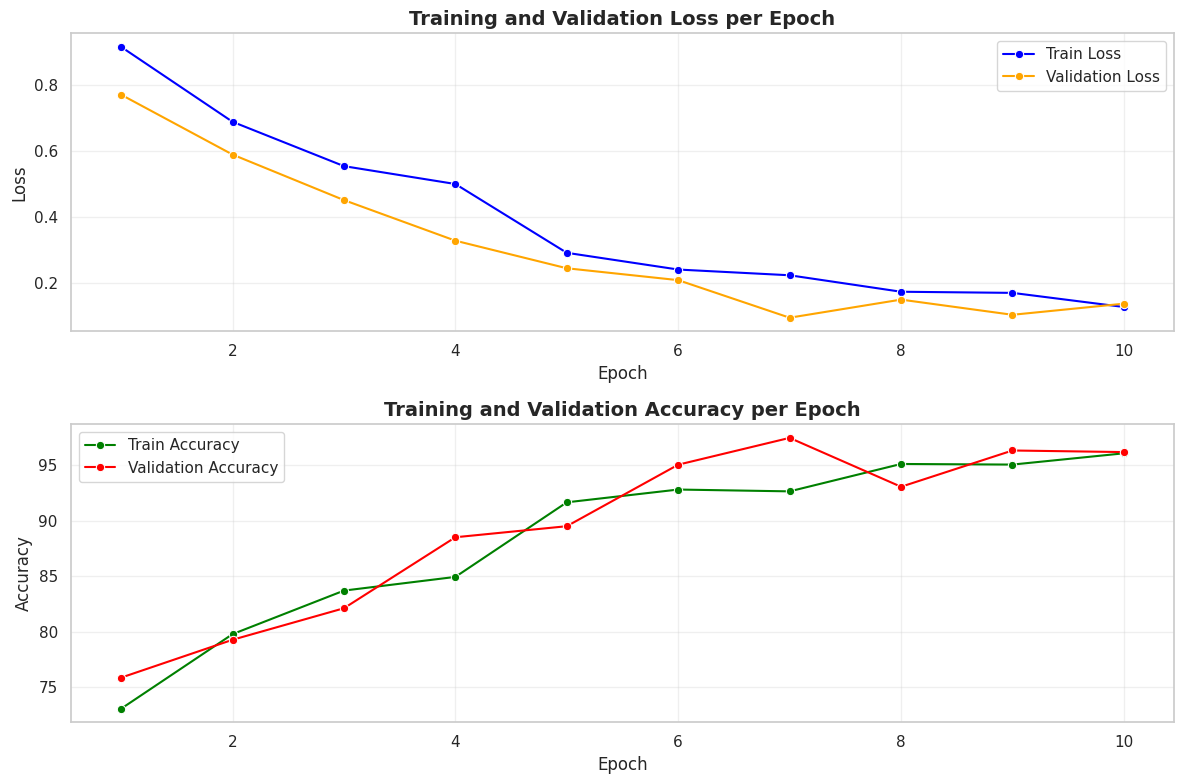

In [24]:
metrics_path = f"{MODEL_NAME}_metrics.csv"  # Path to metrics CSV
metrics_df = pd.read_csv(MODEL_SAVE)

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue', marker="o")
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange', marker="o")
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=metrics_df, label='Train Accuracy', color='green', marker="o")
sns.lineplot(x='epoch', y='val_accuracy', data=metrics_df, label='Validation Accuracy', color='red', marker="o")
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file (optional)
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [25]:
# metrics_df = pd.DataFrame({
#     "epoch": range(1, EPOCHS + 1),
#     "train_loss": train_loss,
#     "train_accuracy": train_accuracy,
#     "val_loss": val_loss,
#     "val_accuracy": val_accuracy,
# })

# # Save the DataFrame to CSV
# metrics_df.to_csv(MODEL_SAVE, index=False)
# print("Training metrics saved to CSV.")

In [26]:
# Load your model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  
    return model

In [27]:
# Predict on validation data
def predict_on_validation(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for inputs, labels in val_loader:  
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [28]:
# Define paths and device
checkpoint_path = "/kaggle/working/swinv2_small_window16_256_epoch_10.pt"
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

# Assuming `dataloaders` is a dictionary with 'val' key containing the validation dataloader
# Predict on validation set
y_true, y_pred = predict_on_validation(model, val_loader, device)


/tmp/ipykernel_23/3995944402.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [29]:
# Generate Classification Report
report = classification_report(y_true, y_pred, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       343
           1       0.92      0.78      0.85        60
           2       0.94      0.96      0.95       197
           3       0.96      1.00      0.98        49
           4       0.87      0.96      0.91        55

    accuracy                           0.96       704
   macro avg       0.94      0.94      0.94       704
weighted avg       0.96      0.96      0.96       704



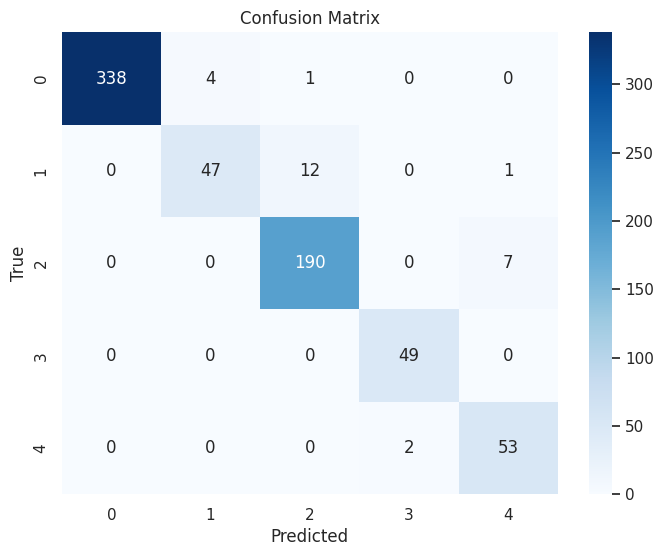

In [30]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [31]:
# Define the level-to-category mapping
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}


class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])  
    incorrect = total - cm[i, i] 
    error_rate = incorrect / total if total != 0 else 0
    class_errors[level_to_category[i]] = round(error_rate, 4)

# Print class errors
for class_name, error_rate in class_errors.items():
    print(f"Class {class_name}: Error Rate = {error_rate}")


Class No_DR: Error Rate = 0.0146
Class Mild: Error Rate = 0.2167
Class Moderate: Error Rate = 0.0355
Class Severe: Error Rate = 0.0
Class Proliferate_DR: Error Rate = 0.0364


In [32]:

error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])


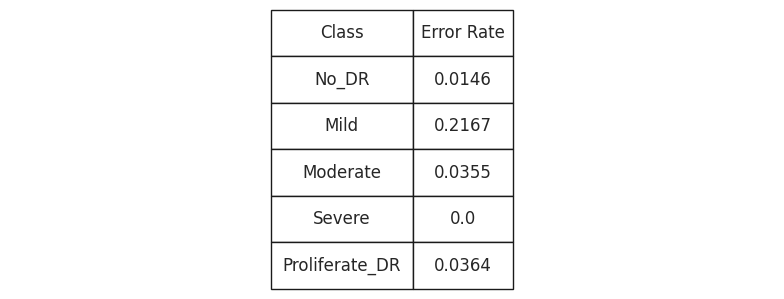

In [33]:
# Plot only the table, fitting the entire figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)

plt.tight_layout()
plt.show()


In [35]:
def process_image(image_path):
    image = cv2.imread(image_path)
    image_cropped = crop_image_from_gray(image)  
    image_resized = cv2.resize(image_cropped, (256, 256))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    blue, green, red = cv2.split(image_rgb)
    blue_clahe = clahe.apply(blue)
    green_clahe = clahe.apply(green)
    red_clahe = clahe.apply(red)
    result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
    result_image = torch.tensor(result_image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # CHW format, normalize between [0, 1]
    result_image = train_transforms_DeiT_base_patch16(result_image)
    
    return result_image

In [36]:
import os
import torch
import pandas as pd
import cv2
from tqdm import tqdm

# Initialize lists to store image names and predictions
image_names = []
predictions = []

def process_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (256, 256))  # Resize image to 256x256
    image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image = image_resized.transpose((2, 0, 1))  # Convert HWC to CHW format
    image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize image
    
    return image.unsqueeze(0)

df_test = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv")
for image_name in tqdm(df_test['id_code'], desc="Predicting on test images"):
    image_path = os.path.join('/kaggle/input/aptos2019-blindness-detection/test_images', f"{image_name}.png")
    image = process_image(image_path).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
    image_names.append(image_name)
    predictions.append(predicted_label.item()) 
results_df = pd.DataFrame({
    'id_code': image_names,
    'diagnosis': predictions
})



Predicting on test images: 100%|██████████| 1928/1928 [02:13<00:00, 14.43it/s]


In [37]:
!pip freeze > requirments.txt